In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.preprocessing import StandardScaler
from finpak.data.fetchers.yahoo import download_multiple_tickers


def get_device():
  if torch.backends.mps.is_available():
      return torch.device("mps")
  elif torch.cuda.is_available():
      return torch.device("cuda")
  else:
      return torch.device("cpu")

# Use this device throughout your code
device = get_device()
print(f"Using device: {device}")

Matplotlib is building the font cache; this may take a moment.


Using device: mps


In [ ]:
import yfinance as yf
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'JPM', 'BAC', 'WFC']
start_date = '2002-04-01'
end_date = '2024-08-31'

data = yf.download(tickers, start=start_date, end=end_date, interval='1d')

/var/folders/_w/sl4l8tnj3gzffndss73z63w40000gn/T/ipykernel_42550/2976663186.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, interval='1d')
[*********************100%***********************]  9 of 9 completed


In [12]:
data.head()

Price           Close                                                         \
Ticker           AAPL       AMZN        BAC       GOOG        JPM       MSFT   
Date                                                                           
2015-04-01  27.653900  18.513000  12.266067  26.852327  45.119812  34.956947   
2015-04-02  27.892048  18.612499  12.369543  26.504400  45.548805  34.587803   
2015-04-06  28.343857  18.851999  12.345664  26.565519  45.511169  35.669476   
2015-04-07  28.045620  18.720501  12.305865  26.578140  45.797173  35.652309   
2015-04-08  27.954367  19.059999  12.425261  26.805309  45.947697  35.557865   

Price                                            High  ...       Open  \
Ticker          NVDA       TSLA        WFC       AAPL  ...        WFC   
Date                                                   ...              
2015-04-01  0.506068  12.506000  39.862759  27.847534  ...  40.217488   
2015-04-02  0.507272  12.733333  40.180550  27.945463  ...  39.870162   
2015-04-06  0.521965  13.540000  39.966232  28.379468  ...  39.774085   
2015-04-07  0.526542  13.550000  39.921898  28.515234  ...  40.114042   
2015-04-08  0.530396  13.844667  39.907104  28.132421  ...  39.892324   

Price          Volume                                                    \
Ticker           AAPL      AMZN       BAC      GOOG       JPM      MSFT   
Date                                                                      
2015-04-01  162485600  49162000  73153900  39261497  18100600  36865300   
2015-04-02  128880400  37506000  50443500  34327989  12697800  37487500   
2015-04-06  148776000  61014000  51189500  26488525  12025200  39223700   
2015-04-07  140049200  39098000  50057800  26057345  11505500  28809400   
2015-04-08  149316800  52728000  71732500  23570536  11734000  24753400   

Price                                       
Ticker           NVDA       TSLA       WFC  
Date                                        
2015-04-01  330768000   56919000  15436900  
2015-04-02  192204000   75156000  13498900  
2015-04-06  515864000  186837000  10786100  
2015-04-07  413964000   65218500  10853700  
2015-04-08  366432000   94546500   9828700  

[5 rows x 45 columns]

In [ ]:

# Download historical data for the tickers
data_df = download_multiple_tickers(tickers, start_date, end_date)

In [4]:
data_df.head()

Price          Close                       High                        Low  \
Ticker          AAPL GOOGL       MSFT      AAPL GOOGL       MSFT      AAPL   
Date                                                                         
2000-04-03  0.999545   NaN  27.755772  1.045938   NaN  29.473804  0.970492   
2000-04-04  0.954559   NaN  27.049465  0.997202   NaN  28.099374  0.875364   
2000-04-05  0.977521   NaN  26.381342  0.996265   NaN  27.030376  0.929722   
2000-04-06  0.938626   NaN  26.266804  1.008449   NaN  26.877660  0.924099   
2000-04-07  0.987830   NaN  27.202171  0.988767   NaN  27.297618  0.940969   

Price                            Open                      Volume        \
Ticker     GOOGL       MSFT      AAPL GOOGL       MSFT       AAPL GOOGL   
Date                                                                      
2000-04-03   NaN  27.488522  1.015947   NaN  28.843859  328563200   NaN   
2000-04-04   NaN  25.942289  0.994391   NaN  27.965749  660329600   NaN   
2000-04-05   NaN  26.228628  0.948232   NaN  26.954019  457665600   NaN   
2000-04-06   NaN  26.042505  0.979395   NaN  26.839481  259627200   NaN   
2000-04-07   NaN  25.961371  0.954090   NaN  26.572226  242435200   NaN   

Price                  
Ticker           MSFT  
Date                   
2000-04-03  260118200  
2000-04-04  181244400  
2000-04-05   82887600  
2000-04-06   66421400  
2000-04-07   82613600

In [ ]:

data_df = data_df.loc[:,'Adj Close'] # Extract from multi-index dataframe

# Compute percentage changes
prices = data_df['AAPL']
data_df['pct_change_1d'] = prices.pct_change(periods=1)
data_df['pct_change_2d'] = prices.pct_change(periods=2)
data_df['pct_change_5d'] = prices.pct_change(periods=5)
data_df['pct_change_10d'] = prices.pct_change(periods=10)
data_df['target'] = data_df['pct_change_1d'].shift(-1)  # Next day's 1-day % change

# Drop NaN values resulting from percentage change calculations
data_df = data_df.dropna()

# Extract features and target
#features = data_df[['pct_change_1d', 'pct_change_2d', 'pct_change_5d', 'pct_change_10d']].values
features = data_df[['pct_change_2d', 'pct_change_5d', 'pct_change_10d']].values
y = data_df['target'].values

# Standardize features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [30]:
"""
- **Create Sequences:**
- Decide on a sequence length (e.g., 10).
- Convert the percentage changes into input-output pairs where each input is a sequence of `sequence_length` steps, and the output is the next value.
"""
sequence_length = 10
X_sequences = []
y_sequences = []

for i in range(len(X_scaled) - sequence_length):
  X_sequences.append(X_scaled[i:i + sequence_length])
  y_sequences.append(y_scaled[i + sequence_length])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

class StockDataset(Dataset):
  def __init__(self, sequences, targets):
      self.sequences = sequences
      self.targets = targets

  def __len__(self):
      return len(self.sequences)

  def __getitem__(self, idx):
      sequence = torch.tensor(self.sequences[idx], dtype=torch.float32).to(device)
      target = torch.tensor(self.targets[idx], dtype=torch.float32).to(device)
      return sequence, target

class SwishActivation(nn.Module):
  def forward(self, x):
      return x * torch.sigmoid(x)

class LSTMLayer(nn.Module):
  def __init__(self, input_size, hidden_size, dropout_p=0.3):
      super(LSTMLayer, self).__init__()
      self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
      self.layer_norm = nn.LayerNorm(hidden_size)
      self.dropout = nn.Dropout(p=dropout_p)  # Add dropout
      self.swish = SwishActivation()

  def forward(self, x, hidden=None):
      out, hidden = self.lstm(x, hidden)
      out = self.dropout(out)
      out = self.layer_norm(out)
      out = self.swish(out)
      return out, hidden

class EnhancedLSTMModel(nn.Module):
  def __init__(self, input_size=2, hidden_size=50, num_layers=2, dropout_p=0.3):
      super(EnhancedLSTMModel, self).__init__()
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      
      self.layers = nn.ModuleList([
          LSTMLayer(input_size if i == 0 else hidden_size, hidden_size, dropout_p)
          for i in range(num_layers)
      ])
      
      self.fc = nn.Linear(hidden_size, 1)
      self.layer_norm_final = nn.LayerNorm(hidden_size)
      self.swish = SwishActivation()

  def forward(self, x):
      batch_size = x.size(0)
      h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
      c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
      hidden = (h0, c0)

      residual = None
      for i, layer in enumerate(self.layers):
          if i == 0:
              out, hidden = layer(x, hidden)
          else:
              layer_input = out if residual is None else out + residual
              out, hidden = layer(layer_input, hidden)
          
          if i > 0:  # Apply residual connection for all layers except the first
              residual = out

      out = self.layer_norm_final(out)
      out = self.swish(out)
      out = self.fc(out[:, -1, :])
      return out.squeeze()

In [31]:
# Create the full dataset
full_dataset = StockDataset(X_sequences, y_sequences)

# Define split ratios
train_ratio = 0.88
val_ratio = 0.12

# Calculate split indices
train_size = int(len(y_sequences) * train_ratio)
val_size = int(len(y_sequences) * val_ratio)

# Split the dataset sequentially
train_dataset = torch.utils.data.Subset(full_dataset, range(train_size))
val_dataset = torch.utils.data.Subset(full_dataset, range(train_size, train_size + val_size))

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [32]:
# Adjust input_size in the model to match the feature size (2 in this case)
INPUT_SIZE = 3
HIDDEN_SIZE = 512
NUM_LAYERS = 2

In [33]:
model = EnhancedLSTMModel(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00075)
best_val_loss = float('inf')

# Use MAE Loss
criterion = nn.L1Loss()

# # Or define a custom loss function
# class DirectionalLoss(nn.Module):
#   def __init__(self):
#       super(DirectionalLoss, self).__init__()
  
#   def forward(self, outputs, targets):
#       # MSE component
#       mse_loss = nn.MSELoss()(outputs, targets)
#       # Directional component
#       direction_correct = torch.eq(torch.sign(outputs), torch.sign(targets)).float()
#       direction_loss = torch.mean(1 - direction_correct)
#       # Total loss
#       total_loss = mse_loss + direction_loss
#       return total_loss

# criterion = DirectionalLoss()

In [34]:
num_epochs = 112
patience = 14  # For early stopping
epochs_without_improvement = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
  model.train()
  epoch_train_loss = 0
  for sequences, targets in train_loader:
      sequences, targets = sequences.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(sequences)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      epoch_train_loss += loss.item()
  
  avg_train_loss = epoch_train_loss / len(train_loader)
  train_losses.append(avg_train_loss)
  
  # Validation phase
  model.eval()
  epoch_val_loss = 0
  with torch.no_grad():
      for sequences, targets in val_loader:
          sequences, targets = sequences.to(device), targets.to(device)
          outputs = model(sequences)
          val_loss = criterion(outputs, targets)
          epoch_val_loss += val_loss.item()
  
  avg_val_loss = epoch_val_loss / len(val_loader)
  val_losses.append(avg_val_loss)
  
  # Print statistics
  print(f'Epoch [{epoch+1}/{num_epochs}]')
  print(f'Train Loss: {avg_train_loss:.4f}')
  print(f'Validation Loss: {avg_val_loss:.4f}')
  
  # Early stopping check
  if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      epochs_without_improvement = 0
      # When saving the model, move it to CPU first
      torch.save(model.to('cpu').state_dict(), 'best_lstm_model.pth')
      model.to(device)  # Move it back to the device if you continue training
      print("New best model saved!")
  else:
      epochs_without_improvement += 1
      if epochs_without_improvement >= patience:
          print(f"Early stopping triggered after {epoch+1} epochs")
          break
  
  print('-' * 50)

Epoch [1/112]
Train Loss: 0.7466
Validation Loss: 0.6200
New best model saved!
--------------------------------------------------
Epoch [2/112]
Train Loss: 0.7179
Validation Loss: 0.6179
New best model saved!
--------------------------------------------------
Epoch [3/112]
Train Loss: 0.7180
Validation Loss: 0.6178
New best model saved!
--------------------------------------------------
Epoch [4/112]
Train Loss: 0.7139
Validation Loss: 0.6137
New best model saved!
--------------------------------------------------
Epoch [5/112]
Train Loss: 0.7147
Validation Loss: 0.6156
--------------------------------------------------
Epoch [6/112]
Train Loss: 0.7138
Validation Loss: 0.6156
--------------------------------------------------
Epoch [7/112]
Train Loss: 0.7159
Validation Loss: 0.6137
--------------------------------------------------
Epoch [8/112]
Train Loss: 0.7153
Validation Loss: 0.6170
--------------------------------------------------
Epoch [9/112]
Train Loss: 0.7136
Validation Loss

In [35]:
"""
### **5. Model Inference and Graphing**

Note: Generating 2-day percentage changes in the inference loop is challenging without actual future prices. For simplicity, we'll adjust the inference to use only existing features.
"""

# Load the trained model
model = EnhancedLSTMModel(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)
model.load_state_dict(torch.load('best_lstm_model.pth', weights_only=False))
model.eval()

EnhancedLSTMModel(
  (layers): ModuleList(
    (0): LSTMLayer(
      (lstm): LSTM(3, 512, batch_first=True)
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (swish): SwishActivation()
    )
    (1): LSTMLayer(
      (lstm): LSTM(512, 512, batch_first=True)
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (swish): SwishActivation()
    )
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (layer_norm_final): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (swish): SwishActivation()
)

In [36]:
# Define the validation set range
val_start = train_size
val_end = train_size + val_size

# Define prediction parameters
prediction_length = 40  # Number of future steps to predict
prediction_interval = 60  # Space between prediction start points

# Function to make predictions
def make_prediction(start_idx):
  # Get the initial input sequence (scaled)
  input_seq_scaled = X_scaled[start_idx:start_idx + sequence_length]  # shape (sequence_length, 2)
  input_seq = torch.tensor(input_seq_scaled, dtype=torch.float32).unsqueeze(0).to(device)

  # Get the unscaled 1-day pct changes for the initial sequence
  past_1d_pcts_unscaled = scaler_y.inverse_transform(y_scaled[start_idx:start_idx + sequence_length].reshape(-1,1)).flatten().tolist()

  # Get the last known price
  last_known_price = prices.iloc[start_idx + sequence_length - 1]

  # Initialize predicted prices list
  predicted_prices = [last_known_price]

  for _ in range(prediction_length):
      # Predict the next 1-day pct change
      with torch.no_grad():
          pred_scaled = model(input_seq)
      pred_scaled = pred_scaled.item()

      # Inverse transform to get unscaled 1d pct change
      pred_unscaled = scaler_y.inverse_transform([[pred_scaled]])[0,0]

      # TODO: MODIFY THIS SO IT MATCHES THE FEATURES USED
      # Append predicted unscaled 1d pct change to past_1d_pcts_unscaled
      past_1d_pcts_unscaled.append(pred_unscaled)
      # Keep only the last two 1d pct changes
      last_two_1d_pcts = past_1d_pcts_unscaled[-2:]

      # Compute synthetic 2-day pct change as sum of last two 1d pct changes
      synthetic_2d_pct_unscaled = sum(last_two_1d_pcts)

      # Scale the new 1d and 2d pct changes to get the new feature vector
      new_feature_unscaled = [pred_unscaled, synthetic_2d_pct_unscaled]
      new_feature_scaled = scaler_X.transform([new_feature_unscaled])[0]

      # Update the input sequence
      input_seq = input_seq.cpu().numpy()
      input_seq = np.concatenate((input_seq[:,1:,:], new_feature_scaled.reshape(1,1,-1)), axis=1)
      input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)

      # Compute the predicted price
      next_price = predicted_prices[-1] * (1 + pred_unscaled)
      predicted_prices.append(next_price)

      # Store the predicted unscaled 1d pct change for future steps
      past_1d_pcts_unscaled = past_1d_pcts_unscaled[-2:]  # Keep only the last two for next iteration

  # Prepare the dates for the predictions
  prediction_dates = data_df.index[start_idx + sequence_length - 1 : start_idx + sequence_length - 1 + prediction_length +1]

  return prediction_dates, predicted_prices

# Make predictions at intervals
prediction_starts = range(val_start, val_end - sequence_length - prediction_length, prediction_interval)
all_prediction_data = [make_prediction(start) for start in prediction_starts]

# Prepare actual price data for the entire validation period
val_dates = data_df.index[val_start + sequence_length - 1:val_end + 1]
val_prices = prices.iloc[val_start + sequence_length - 1:val_end + 1]

# Plotting
plt.figure(figsize=(15, 8))

# Plot actual stock price
plt.plot(val_dates, val_prices, label='Actual Stock Price', color='blue', linewidth=2)

# Plot prediction lines
for dates, predicted_prices in all_prediction_data:
  plt.plot(dates, predicted_prices, color='red', alpha=0.5, linewidth=1)

plt.title('LSTM Model: Multiple Predictions vs Actual Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

ValueError: X has 2 features, but StandardScaler is expecting 3 features as input.

/var/folders/cw/rw396n655kx_hcjt2ldbh38r0000gn/T/ipykernel_7542/440173003.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_train_price = prices[train_size + sequence_length - 1]


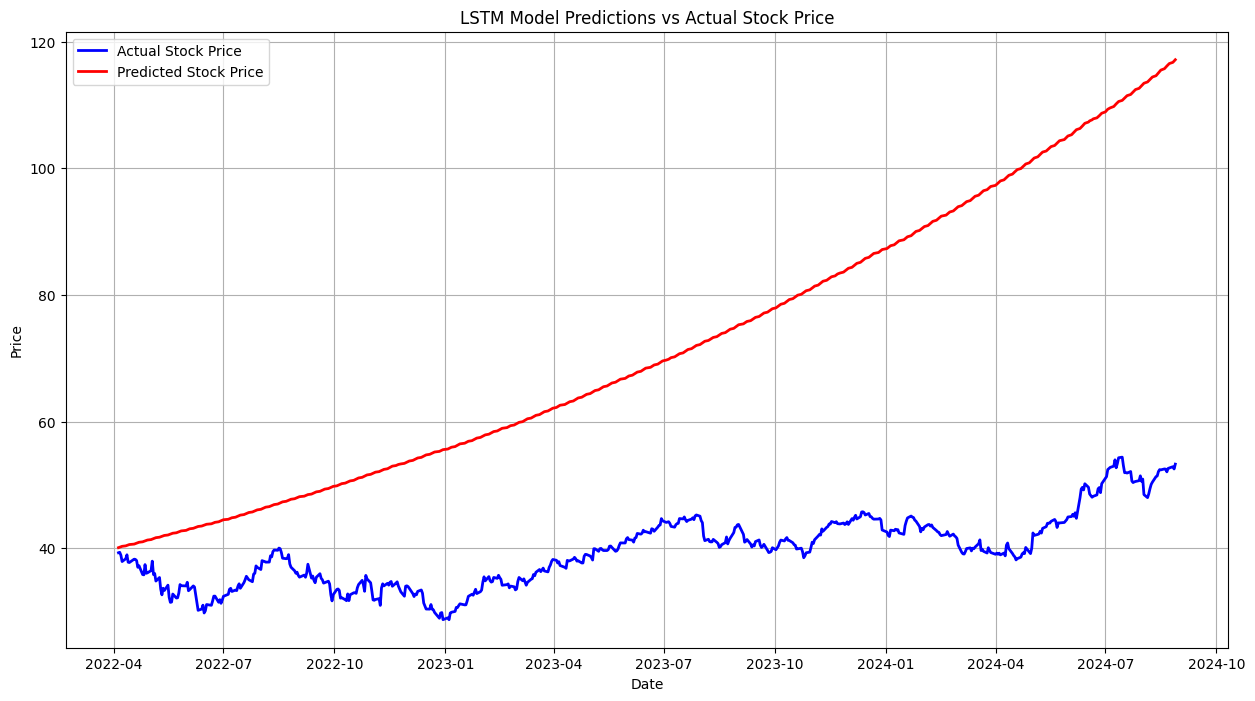

In [37]:
# Prepare data for plotting
# Use the validation set for predictions
val_features = X_sequences[train_size:train_size + val_size]
val_targets = y_sequences[train_size:train_size + val_size]

# Get predictions
model_predictions = []
with torch.no_grad():
  for sequence in val_features:
      sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).to(device)
      prediction = model(sequence)
      model_predictions.append(prediction.item())

# Inverse transform the predictions and targets
model_predictions = scaler_y.inverse_transform(np.array(model_predictions).reshape(-1, 1)).flatten()
actual_targets = scaler_y.inverse_transform(val_targets.reshape(-1, 1)).flatten()

# Since the target is the next day's percentage change, reconstruct the predicted prices
# Start from the last price in the training set
last_train_price = prices[train_size + sequence_length - 1]
predicted_prices = [last_train_price]
actual_prices = [last_train_price]

for pred_pct_change in model_predictions:
  next_price = predicted_prices[-1] * (1 + pred_pct_change)
  predicted_prices.append(next_price)

for actual_pct_change in actual_targets:
  next_price = actual_prices[-1] * (1 + actual_pct_change)
  actual_prices.append(next_price)

# Remove the first element as it was the initial price
predicted_prices = predicted_prices[1:]
actual_prices = actual_prices[1:]

# Prepare dates for plotting
val_dates = data_df.index[train_size + sequence_length:train_size + sequence_length + val_size]

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(val_dates, actual_prices, label='Actual Stock Price', color='blue', linewidth=2)
plt.plot(val_dates, predicted_prices, label='Predicted Stock Price', color='red', linewidth=2)
plt.title('LSTM Model Predictions vs Actual Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()